## Assignment 7
### Pradeep Mundlik (AI21BTECH11022)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import emcee
from scipy import optimize
from sklearn.neighbors import KernelDensity
import nestle
from astropy import stats as stats_astropy
from astroML import stats as stats_astroML

### Q-1

In [20]:
# extracting data from the website
data = np.loadtxt('https://iith.ac.in/~shantanud/fgas_spt.txt')
z = data[:, 0]
fgas = data[:, 1]
fgas_error = data[:, 2]

# utility function for log prior
def log_prior(theta):
    m, b = theta
    if -0.5 < m < 0.5 and 0 < b < 0.5:
        return 0.0
    return -np.inf

# utility function for log likelihood
def log_llihood(theta, x, y, y_error):
    m, b = theta
    y_model = b*(1+m*x)
    return -0.5 * np.sum(((y_model - y)/y_error)**2)

# function for log posterior
def log_posterior(theta, x, y, y_error):
    log_pr = log_prior(theta)
    if not np.isfinite(log_pr):
        return -np.inf
    return log_pr + log_llihood(theta, x, y, y_error)

In [21]:

# MCMC walkers
nwalkers = 50
# number of final posterior samples
nsamples = 1000  
# burn period
nburn = 1000
# number of MCMC nsteps
nsteps = nburn + nsamples

# initial guesses
guesses = np.array([np.random.uniform(-0.5, 0.5, nwalkers), np.random.uniform(0.0, 0.5, nwalkers)]).T 
# number of dimensions
ndims = guesses.shape[1] 

sampler = emcee.EnsembleSampler(nwalkers, ndims, log_posterior, args=[z,fgas,fgas_error])
sampler.run_mcmc(guesses, nsteps)
samples = sampler.chain[:, nburn:, :].reshape((-1, ndims))

In [22]:
# function for calculating sigma level
def sigma_level(t1, t2, nbins=20):
    L, xbins, ybins = np.histogram2d(t1, t2, nbins)
    L[L == 0] = 1E-16

    shape = L.shape
    L = L.ravel()

    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)
    # cumulative sum
    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]

    sigma = L_cumsum[i_unsort].reshape(shape)

    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])
    return xbins, ybins, sigma

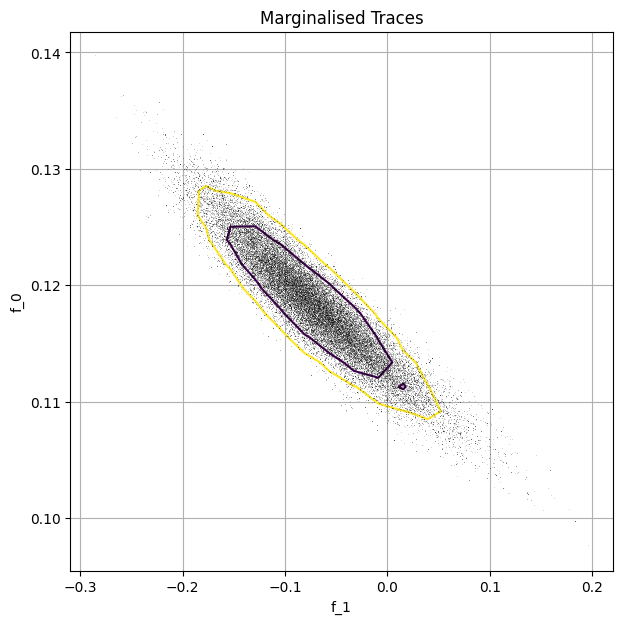

In [23]:
# plotting marginalised traces
trace = samples.T
xbins, ybins, sigma = sigma_level(trace[0],trace[1])

plt.figure(figsize=(7,7))
plt.contour(xbins, ybins, sigma.T, levels=[0.68,0.90])
plt.plot(trace[0], trace[1], ',k', alpha=0.15)

plt.title("Marginalised Traces")
plt.xlabel('f_1')
plt.ylabel('f_0')
plt.grid()
plt.show()

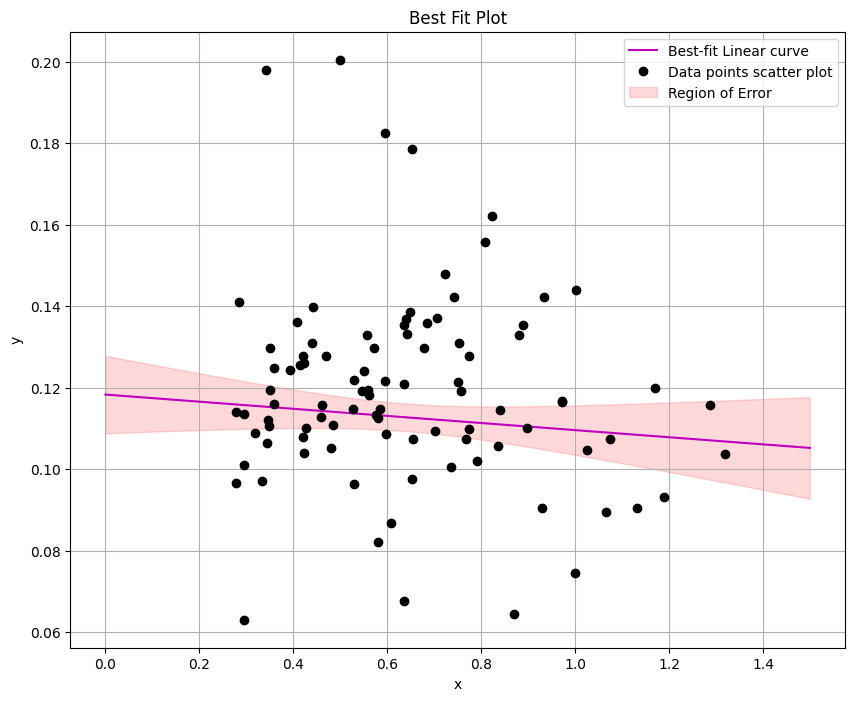

Best fit parameters are:  -0.07171876652298201 0.1182997151981786


In [24]:
# plotting best fit curves
x1 = np.linspace(0, 1.5, 2000)
m, b = trace[:2]
y1 = b[:,None]*(1+m[:,None]*x1)
# for error region bounds
bound1 = y1.mean(0)-2*y1.std(0)
bound2 = y1.mean(0)+2*y1.std(0)

plt.figure(figsize=(10,8))
plt.plot(x1, y1.mean(0),'-m', label='Best-fit Linear curve')
plt.plot(z, fgas, 'ok', label='Data points scatter plot')
plt.fill_between(x1, bound1, bound2, alpha=0.15, color = 'r', label='Region of Error')

plt.xlabel('x')
plt.ylabel('y')
plt.title("Best Fit Plot")
plt.grid()
plt.legend()
plt.show()

print("Best fit parameters are: ", np.mean(m), np.mean(b))

### Q-2

In [25]:
data = np.array([[0.42,  0.72,  0.,  0.3,  0.15,0.09,  0.19,  0.35,  0.4,  0.54,
                  0.42,  0.69,  0.2,  0.88,  0.03,0.67,  0.42,  0.56,  0.14,  0.2],
                 [0.33,  0.41, -0.22,  0.01, -0.05, -0.05, -0.12,  0.26,  0.29,  0.39,
                  0.31,  0.42, -0.01,  0.58, -0.2, 0.52,  0.15,  0.32, -0.13, -0.09],
                 [0.1,  0.1,  0.1,  0.1,  0.1, 0.1,  0.1,  0.1,  0.1,  0.1,
                  0.1,  0.1,  0.1,  0.1,  0.1, 0.1,  0.1,  0.1,  0.1,  0.1]])

In [26]:
# function for polynomial fit
def polynomial_fit(theta, x):
    return sum(t * x ** n for (n, t) in enumerate(theta))

# function for log likelihood
def log_llihood(theta, data=data):
    x, y, sigma_y = data
    yM = polynomial_fit(theta, x)
    return -0.5 * np.sum(np.log(2 * np.pi * sigma_y ** 2) + (y - yM) ** 2 / sigma_y ** 2)

# function for prior
def prior(theta):
    return 200*theta - 100

In [27]:
x, y, sigma_y = data
result_lin = nestle.sample(log_llihood, prior, 2)
print(result_lin.summary())
result_quad = nestle.sample(log_llihood, prior, 3)
print()
print(result_quad.summary())

niter: 1534
ncall: 2982
nsamples: 1634
logz:  7.543 +/-  0.368
h: 13.540

niter: 2112
ncall: 3886
nsamples: 2212
logz:  2.596 +/-  0.433
h: 18.776


#### **The above values don't agree with the blog**

### Q-3

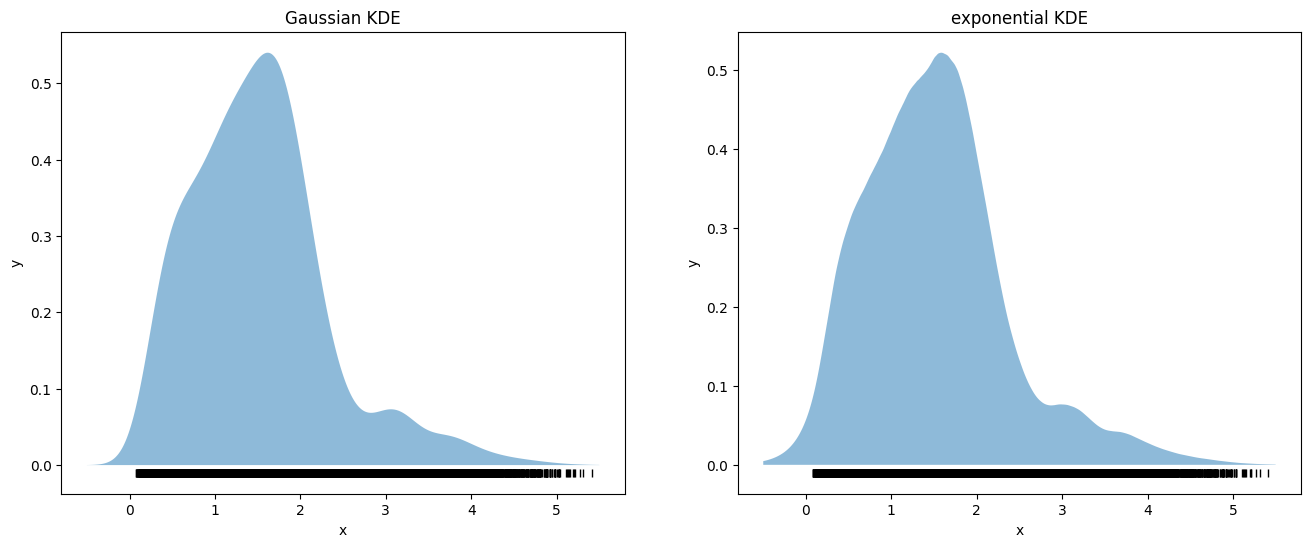

In [28]:
dataframe = pd.read_csv('a7q3testfile.csv')
data2 = dataframe['z']
z = data2.to_numpy()
x_d = np.linspace(-0.5,5.5,1000)

fig, ax = plt.subplots(1,2,figsize=(16, 6))

kde1 = KernelDensity(bandwidth=0.2, kernel='gaussian')
kde1.fit(z[:, None])

logprob = kde1.score_samples(x_d[:, None])

ax[0].fill_between(x_d, np.exp(logprob), alpha=0.5)
ax[0].plot(z, np.full_like(z, -0.01), '|k', markeredgewidth=1)
ax[0].set(title='Gaussian KDE',xlabel='x',ylabel='y')

kde2 = KernelDensity(bandwidth=0.2, kernel='exponential')
kde2.fit(z[:, None])

logprob = kde2.score_samples(x_d[:, None])

ax[1].fill_between(x_d, np.exp(logprob), alpha=0.5)
ax[1].plot(z, np.full_like(z, -0.01), '|k', markeredgewidth=1)
ax[1].set(title='exponential KDE',xlabel='x',ylabel='y')

plt.show()